### Code block 1: Package initialization
Import required packages, do not change.

### 6. Lab: Simple NN

In [ ]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple

### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [ ]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation, 
            groups, bias, padding_mode)
    
    def forward(self, input):
        self.input = input
        if '1.4' in torch.__version__:
            self.output = self.conv2d_forward(input, self.weight, self.bias) #1.4
        else:
            self.output = self._conv_forward(input, self.weight, self.bias) #1.5
        return self.output
    
class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)
    
    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: SimpleNN implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

In [ ]:
""" 
Lab 2(a)
Build the SimpleNN model by following Table 1
"""

# Create the neural network module: LeNet-5
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 =     CONV(3,32,5,1,2) #Your code here
        self.conv2 =     CONV(32,32,kernel_size=5, stride=1, padding=2) #Your code here
        self.conv3 =     CONV(32,64,kernel_size=5, stride=1, padding=2) #Your code here
        self.fc1   =     FC(3*3*64, 64) #Your code here
        self.fc2   =     FC(64, 10) #Your code here

    def forward(self, x):
        # Forward pass computation
        # Conv 1
        out = F.relu(self.conv1(x))
        # MaxPool
        out = F.max_pool2d(out, 3, 2)
        # Conv 2
        out = F.relu(self.conv2(out))
        # MaxPool
        out = F.max_pool2d(out, 3, 2)
        # Conv 3
        out = F.relu(self.conv3(out))
        # MaxPool
        out = F.max_pool2d(out, 3, 2) 
        # Flatten
        out = out.view(out.size(0), -1)
        # FC 1
        out = F.relu(self.fc1(out))
        # FC 2
        out = self.fc2(out)
        return out

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)     #Your code here

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on CPU...
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

In [ ]:
"""
Lab 2(b)
"""

# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)    #Your code here

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the input feature map of the module as a NumPy array
        input = module.input.detach().numpy() #Your code here
        # Get the output feature map of the module as a NumPy array
        output = module.output.detach().numpy() #Your code here
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().numpy() #Your code here
        param = 1
        for i in weight.shape:
          if i != 0: 
            param = param * i
          else:
            break
        # Compute the number of parameters in the weight
        if isinstance(module, CONV):
          # num of param for conv = ((kernel_size)*stride+1)*filters) 
          # multiple weights shape together 
          num_Param = param
          # Compute the number of MACs in the layer
          # MAC for conv = Number of Kernels x Kernel Shape x Output Shape
          num_MAC = module.in_channels * module.out_channels * module.kernel_size[0] * module.kernel_size[1] * module.output.size()[2] * module.output.size()[3]
        else:
          num_Param = param
          # MAC for FC = Input Size x Output Size
          num_MAC = module.input.size()[0] * module.input.size()[1] * module.output.size()[0] * module.output.size()[1]
        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')


conv1      (1, 3, 32, 32)       (1, 32, 32, 32)      (32, 3, 5, 5)        2400       2457600   
conv2      (1, 32, 15, 15)      (1, 32, 15, 15)      (32, 32, 5, 5)       25600      5760000   
conv3      (1, 32, 7, 7)        (1, 64, 7, 7)        (64, 32, 5, 5)       51200      2508800   
fc1        (1, 576)             (1, 64)              (64, 576)            36864      36864     
fc2        (1, 64)              (1, 10)              (10, 64)             640        640       


In [ ]:
# check
from torchsummary import summary
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              CONV-1           [-1, 32, 32, 32]           2,400
              CONV-2           [-1, 32, 15, 15]          25,600
              CONV-3             [-1, 64, 7, 7]          51,200
                FC-4                   [-1, 64]          36,928
                FC-5                   [-1, 10]             650
Total params: 116,778
Trainable params: 116,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.33
Params size (MB): 0.45
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


Layer  | Input Shape | Output Shape  | Wieght shape | # Param | # MAC |
-------------------|------------------|------------------|------------------ |------------------|------------------|
Conv 1|(1, 3, 32, 32)|(1, 32, 32, 32) | (32, 3, 5, 5) | 2,400 |2457600 |
Conv 2|(1, 32, 15, 15) |(1, 32, 15, 15) | (32, 32, 5, 5) | 25,600 | 5760000 |
Conv 3|(1, 3, 32, 32)|(1, 32, 32, 32) | (64, 32, 5, 5) | 51,200 | 2508800  |
FC1 |(1, 576)|(1, 64 | (64, 576) | 36,928 | 36864 |
FC2 |(1, 64)|(1, 10) | (10, 64) | 650 | 640 |

## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

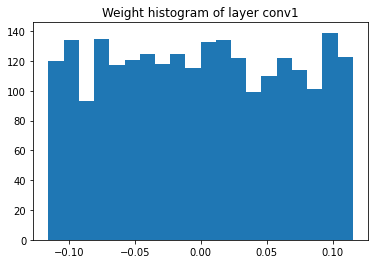

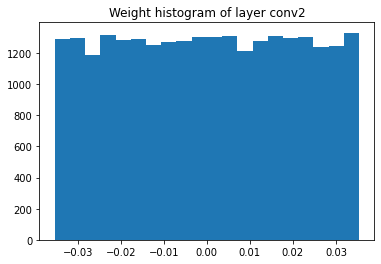

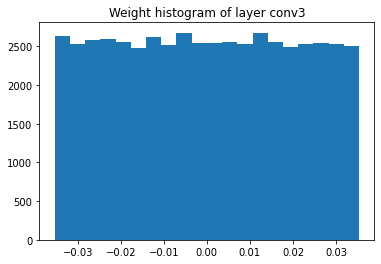

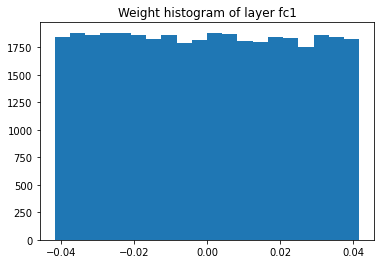

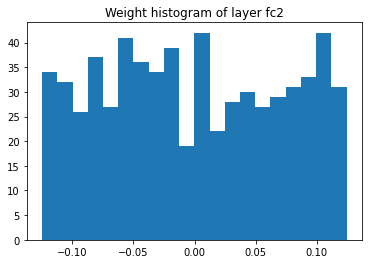

In [ ]:
"""
Lab 3(a)
"""
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().numpy()     #Your code here
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

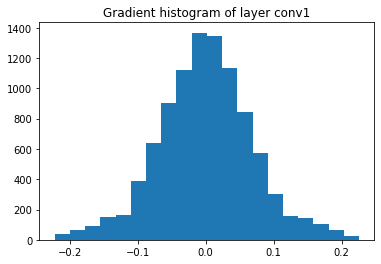

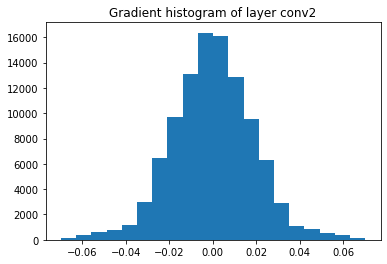

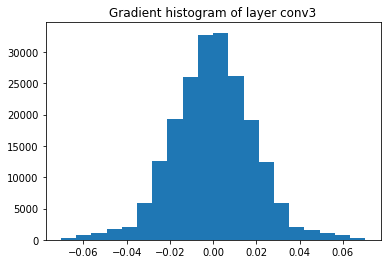

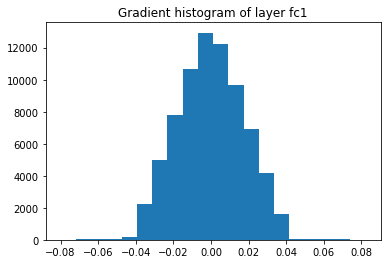

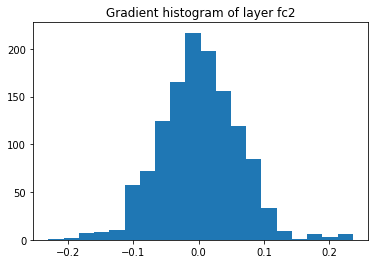

In [ ]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()
# Random target
target = torch.randn(1, 10).to(device)

# Loss computation
loss = criterion(net.forward(data), target)     #Your code here
# Backward pass for gradients
loss.backward() #Your code here

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        weights = module.weight.detach().numpy()
        gradient = np.array(np.gradient(weights)) #Your code here
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()


### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


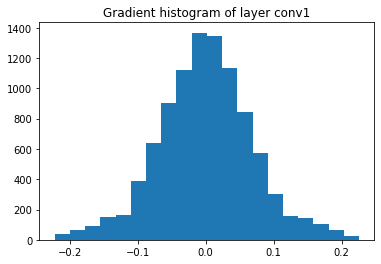

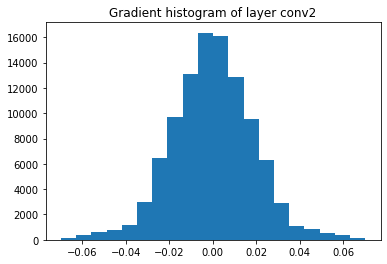

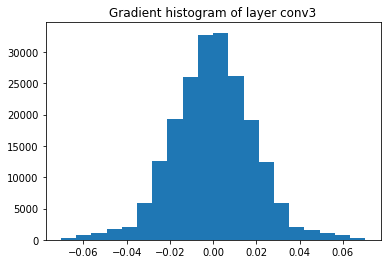

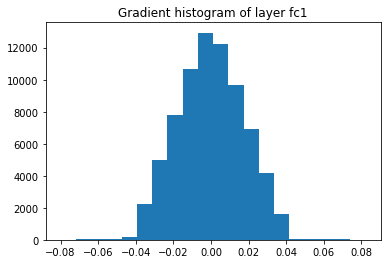

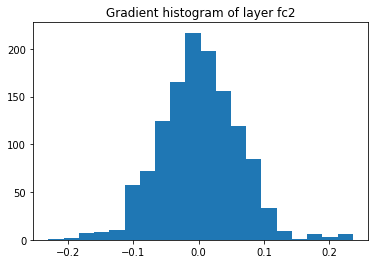

In [ ]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Set the weight of each module to all zero
            module.weights = torch.zeros(5, 3, dtype=torch.long) #Your code here

# Reset gradients
net.zero_grad()
        
# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net.forward(data) #Your code here
# Loss computation
loss = criterion(out, target) #Your code here
# Backward pass
loss.backward() #Your code here

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        weights = module.weight.detach().numpy()
        gradient = np.array(np.gradient(weights)) #Your code here
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()